In [2]:
import pandas as pd
import numpy as np
import sys
from sklearn.linear_model import LinearRegression
import import_ipynb
from hall_data import doping, anneal

importing Jupyter notebook from hall_data.ipynb


# Get image data

In [3]:
sample_datafile = '../data/rho_c/sample_images/data.pkl'
image_df = pd.read_pickle(sample_datafile)

Filter out TNO data

In [4]:
image_df = image_df[image_df.apply(lambda x: 'TNO' not in x['sample name'], axis = 1)]
#image_df = image_df[image_df.apply(lambda x: 'pSi' in x['sample name'], axis = 1)]
#image_df = image_df[image_df.apply(lambda x: 'r96' in x['sample name'] or 'r48' in x['sample name'], axis = 1)]

Handle sample names

In [5]:
def extract_parameters(x):
    keys = ['substrate', 'doping', 'anneal']
    values = x['sample name'].split('_')[:3]
    res = dict(zip(keys, values))
    piece = 'piece' + str(int(x.piece))
    res['piece'] = piece
    return pd.Series({**x, **res})

image_df = image_df.apply(extract_parameters, axis = 1)

Calculate sample area.

In [6]:
COIN_RADIUS = 20.25 /(2*10) # cm (diameter to radius, mm to cm)
REFERENCE_AREA = np.pi*COIN_RADIUS**2 # cm^2

def get_area(x):
    return REFERENCE_AREA*x['pixels']/x['ref pixels']

image_df = image_df.assign(area = get_area)

# Get IVt data

In [7]:
IVt_folder = '../data/rho_c/'
sys.path.append(IVt_folder)
import getData
rho_df = getData.get_all_data()

Fit measured resistance.

In [8]:
def fit_resistance(x):
    data = x.data
    [[R]] = LinearRegression().fit(data.I.values.reshape(-1,1),
                              data.V.values.reshape(-1,1)).coef_
    return R

rho_df = rho_df.apply(lambda x: pd.Series({**x, 'R' : fit_resistance(x)}), axis = 1)

# Merge image and resistance data

In [9]:
full_df = rho_df.merge(image_df, 
                       on = ['substrate', 'doping', 'anneal', 'piece'],
                       #how = 'outer',
                      )
full_df.doping = full_df.doping.astype(doping)
#full_df.anneal = full_df.doping.astype(anneal)
full_df = full_df.assign(rho_s = lambda x: x.R*x.area)
full_df = full_df.assign(rho_c = lambda x: x.rho_s/2)

In [10]:
df = full_df[['piece','substrate', 'doping', 'anneal', 'R', 'area', 'rho_c']]
df

,piece,substrate,doping,anneal,R,area,rho_c
0,piece1,260nplus,r96,400C,0.063699,0.714584,0.022759
1,piece0,260nplus,int,500C,6.034122,0.580364,1.750993
2,piece3,pSi,r96,500C,0.234367,0.413911,0.048504
3,piece3,pSi,r96,500C,0.234367,0.512673,0.060077
4,piece3,pSi,r96,500C,0.128091,0.413911,0.026509
5,piece3,pSi,r96,500C,0.128091,0.512673,0.032834
6,piece1,pSi,r96,400C,130.043853,1.338008,86.999835
7,piece1,pSi,r96,400C,130.043853,0.483451,31.434930
8,piece1,260nplus,r96,500C,0.180149,0.692040,0.062335
9,piece1,pSi,int,400C,28.140290,0.383399,5.394476


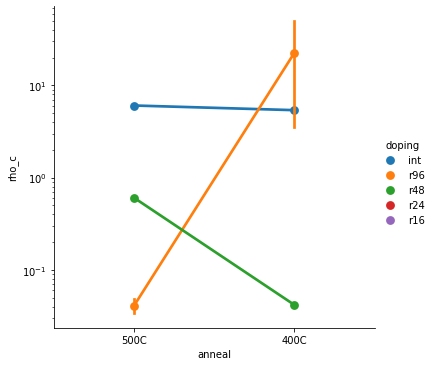

In [11]:
if __name__ == "__main__":
    import seaborn as sns
    p = sns.catplot(x = 'anneal', y = 'rho_c', hue = 'doping', kind = 'point', data = full_df[full_df.substrate == 'pSi'])
    p.set(yscale = 'log')

/home/bart/.local/lib/python3.8/site-packages/seaborn/axisgrid.py:49: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  ax.set(**kwargs)


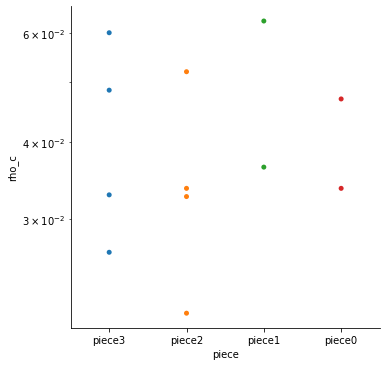

In [47]:
p = sns.catplot(
    data = (df
            #.assign(lbl = lambda data: pd.Series(list(zip(data.anneal, data.doping, data.substrate))).astype(pd.CategoricalDtype())),
            .assign(lbl = lambda d: d.substrate.str.cat(others = [d.doping, d.anneal], sep = ' '))
            .query('doping == "r96" and substrate == "pSi" and anneal == "500C"')
           ),
    x = 'piece',
    y = 'rho_c',
    #hue = 'piece',
    # col = 'substrate',
    kind = 'swarm',
)

p.set(
    yscale = 'log',
    ylim = [0, None],
)

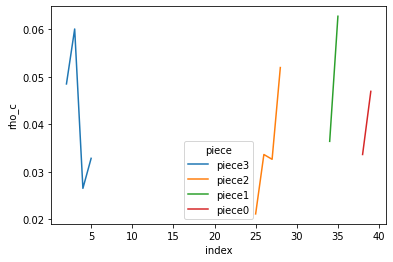

In [56]:
data = (df
            #.assign(lbl = lambda data: pd.Series(list(zip(data.anneal, data.doping, data.substrate))).astype(pd.CategoricalDtype())),
            .assign(lbl = lambda d: d.substrate.str.cat(others = [d.doping, d.anneal], sep = ' '))
            .query('doping == "r96" and substrate == "pSi" and anneal == "500C"')
           )

p = sns.lineplot(
    data = data.reset_index(),
    x = 'index',
    y = 'rho_c',
    hue = 'piece',
)

In [54]:
data.reset_index()

,index,piece,substrate,doping,anneal,R,area,rho_c,lbl
0,2,piece3,pSi,r96,500C,0.234367,0.413911,0.048504,pSi r96 500C
1,3,piece3,pSi,r96,500C,0.234367,0.512673,0.060077,pSi r96 500C
2,4,piece3,pSi,r96,500C,0.128091,0.413911,0.026509,pSi r96 500C
3,5,piece3,pSi,r96,500C,0.128091,0.512673,0.032834,pSi r96 500C
4,25,piece2,pSi,r96,500C,0.080777,0.523058,0.021125,pSi r96 500C
5,26,piece2,pSi,r96,500C,0.080777,0.832926,0.033640,pSi r96 500C
6,27,piece2,pSi,r96,500C,0.124755,0.523058,0.032627,pSi r96 500C
7,28,piece2,pSi,r96,500C,0.124755,0.832926,0.051956,pSi r96 500C
8,34,piece1,pSi,r96,500C,0.093486,0.778945,0.036410,pSi r96 500C
9,35,piece1,pSi,r96,500C,0.093486,1.342683,0.062761,pSi r96 500C
